In [1]:
import os 
os.chdir('../../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.baseline_functions as base
import stumps
import RiskSLIM as slim

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# restore saved variables
%store -r summary_M2_broward_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test
no stored variable summary_M2_broward_interpret


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [2]:
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_data.csv")
x = data.loc[:,:'five_year']
y = data['recid_M2'].values

In [3]:
#### CART
depth = [1,2]
impurity = [0.001, 0.003]
split = [2,3,4]
cart_summary = base.CART(X=x,
                         Y=y,
                         depth=depth,
                         split=split,
                         impurity=impurity, 
                         seed = 816)

#### EBM
estimators = [60, 80, 100]
depth = [1]
learning_rate = [0.05]
holdout_split = [0.9]
ebm_summary = base.EBM(X=x,
                       Y=y,
                       learning_rate = learning_rate,
                       depth = depth,
                       estimators=estimators,
                       holdout_split=holdout_split,
                       seed=816)

model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [38]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [34]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [0]}


get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [0]}


get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [0]}


get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


In [12]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.572530257448205, 0.04501022166523705)

In [13]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.634597763465176, 0.05052023649391877)

## Lasso Stumps

In [14]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'five_year>=1'], data['recid_M2'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[3:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_test_stumps.csv")

X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'five_year>=1'], train_stumps['recid_M2'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'five_year>=1'], test_stumps['recid_M2'].values

Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

#### Nested Cross Validation

In [57]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.01, 0.03, 0.05, 0.07]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [186]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [172]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [192]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [178]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [185]}
get_disparity_predefined_group()


In [58]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.07}, {'C': 0.07}, {'C': 0.07}, {'C': 0.07}, {'C': 0.07}],
 0.6107367126903137,
 0.050672540309280326)

##### Best Stump Model

In [31]:
best_stump_model = stumps.stump_model(X_train_stumps, Y_train_stumps, 
                                      X_test_stumps, Y_test_stumps, 
                                      c=0.05, columns=cols, seed=816)

##### Prediction Table

In [32]:
stumps.stump_table(best_stump_model['coefs'], 
                   best_stump_model['features'], 
                   best_stump_model['intercept'], 
                   best_stump_model['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| p_current_age>=27                 | -0.4           |
| p_current_age>=29                 | -18.1          |
| p_current_age>=30                 | -9.0           |
| p_age_first_offense<=18           | 1.0            |
| p_age_first_offense<=30           | 10.7           |
| p_felprop_violarrest>=1           | -21.1          |
| p_felprop_violarrest>=2           | -9.8           |
| prior_conviction_F>=2             | -2.1           |
| prior_conviction_M>=2             | 12.1           |
| prior_conviction_M>=4             | 1.6            |
| prior_conviction_M>=5             | 0.1            |
| p_arrest>=4                       | 10.4           |
| p_drug>=1                         | 4.8            |
| p_stealing>=2                     | -1.1           |
| years_since_last_crime>=1         | -16.3          |
| years_si

##### Stumps Visualization

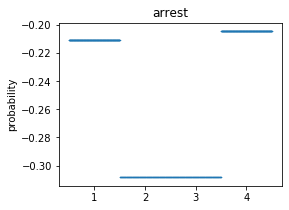

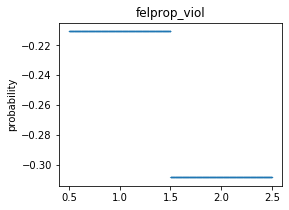

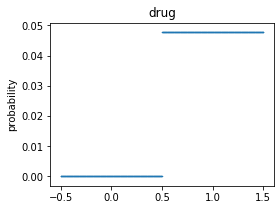

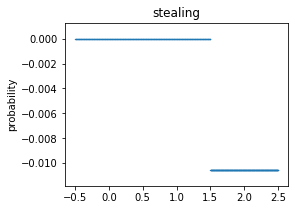

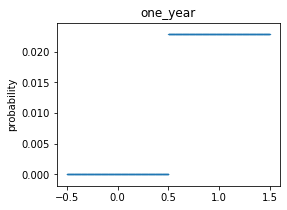

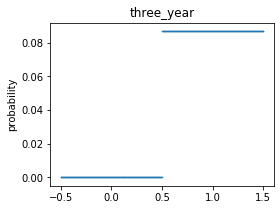

In [33]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'])

## RiskSLIM

In [63]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_stumps.csv")
x, y = data.loc[:,:'five_year>=1'], data['recid_M2'].values
cols = x.columns[3:]

In [85]:
## train on best param chosen by Lasso Stumps from above
x_train = x.copy().drop(['race', 'person_id', 'screening_date'], axis=1)
lasso = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.05, random_state=816).fit(x_train,y)
selected_features = cols[lasso.coef_[0] != 0].tolist()
len(selected_features)

21

In [86]:
### Subset features
if 'sex' in selected_features:
    selected_features = ['recid_M2', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['recid_M2', 'person_id', 'screening_date', 'race', 'sex'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [87]:
riskslim_summary = slim.risk_cv(X=sub_X, 
                                Y=sub_Y, 
                                indicator = 1,
                                y_label='recid_M2', 
                                max_coef=20, 
                                max_coef_number=8, 
                                max_runtime=200, 
                                c=1e-8, 
                                seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
09/10/19 @ 10:32 AM | switching loss computation from lookup to weighted
09/10/19 @ 10:32 AM | ------------------------------------------------------------
09/10/19 @ 10:32 AM | runnning initialization procedure
09/10/19 @ 10:32 AM | ------------------------------------------------------------
09/10/19 @ 10:32 AM | CPA produced 2 cuts
09/10/19 @ 10:32 AM | running naive rounding on 49 solutions
09/10/19 @ 10:32 AM | best objective value: 0.5674
09/10/19 @ 10:32 AM | rounding produced 5 integer solutions
09/10/19 @ 10:32 AM | best objective value is 0.5748
09/10/19 @ 10:32 AM | running sequential rounding on 49 solutions
09/10/19 @ 10:32 AM | best objective value: 0.5674
09/10/19 @ 10:32 AM | sequential rounding produced 3 integer solutions
09/10/19 @ 10:32 AM | best objective value: 0.5748
09/10/19 @ 10:32 AM | polishing 8 solutions
09/10/19 @ 10:32 AM | best objective value: 0.5748
09/10/19 @ 10:32 AM | polishing produced 5 in

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/10/19 @ 10:32 AM | adding 156 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5748.
Tried aggregator 1 time.
Reduced MIP has 24 rows, 48 columns, and 91 nonzeros.
Reduced MIP has 22 binaries, 24 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/10/19 @ 10:32 AM | adding 174 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5710.
Tried aggregator 1 time.
Reduced MIP has 24 rows, 48 columns, and 91 nonzeros.
Reduced MIP has 22 binaries, 24 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/10/19 @ 10:33 AM | adding 136 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5718.
Tried aggregator 1 time.
Reduced MIP has 24 rows, 48 columns, and 91 nonzeros.
Reduced MIP has 22 binaries, 24 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/10/19 @ 10:33 AM | adding 166 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5706.
Tried aggregator 1 time.
Reduced MIP has 24 rows, 48 columns, and 91 nonzeros.
Reduced MIP has 22 binaries, 24 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/10/19 @ 10:33 AM | adding 150 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5716.
Tried aggregator 1 time.
Reduced MIP has 24 rows, 48 columns, and 91 nonzeros.
Reduced MIP has 22 binaries, 24 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

In [88]:
np.mean(riskslim_summary['train_auc']), np.mean(riskslim_summary['test_auc'])

(0.5796779623104039, 0.5798121917788827)

## Arnold PSA

In [89]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_arnold.csv")
X_arnold_raw = data['arnold_nca_raw'].values
X_arnold_calc = data['arnold_nca'].values
Y_arnold = data['recid_M2'].values

In [90]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []
calc_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_pred_calc, y_test = X_arnold_raw[test], X_arnold_calc[test], Y_arnold[test]
    raw_auc.append(roc_auc_score(y_test, y_pred_raw))
    calc_auc.append(roc_auc_score(y_test, y_pred_calc))
    i+=1 

### Results

In [91]:
#### save results
summary_M2_broward_interpret = {"CART": cart_summary,
                                   "EBM": ebm_summary, 
                                   'Lasso Stumps': stump_summary, 
                                   'RiskSLIM': riskslim_summary, 
                                   'Arnold PSA Raw': raw_auc, 
                                   'Arnold PSA': calc_auc}
%store summary_M2_broward_interpret

Stored 'summary_M2_broward_interpret' (dict)


In [92]:
results = [["CART", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["EBM", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["Lasso Stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['RiskSLIM', np.mean(riskslim_summary['test_auc'])],
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3)]]
results

[['CART', 0.572530257448205, 0.04501022166523705],
 ['EBM', 0.634597763465176, 0.05052023649391877],
 ['Lasso Stumps', 0.6107367126903137, 0.050672540309280326],
 ['RiskSLIM', 0.5798121917788827],
 ['Arnold PSA Raw', 0.551],
 ['Arnold PSA', 0.546]]

In [93]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc'])]

In [94]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model results/Advanced Models/Two Year/"
results = [["Misdemeanor", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(raw_auc), 3)) + " (" + np.str(round(np.std(raw_auc),3)) + ")", 
            np.str(round(np.mean(calc_auc), 3)) + " (" + np.str(round(np.std(calc_auc),3)) + ")"]]
with open(path + 'Interpretable Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)